# ทำนายผลผลิตข้าวโพด โดยใช้ผลผลิตปีก่อน ๆ ด้วย SARIMAX


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

register_matplotlib_converters()

import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

----
## Get Data

Read yield data

In [2]:
yield_file = 'OAE-process/OAE-ผลผลิตข้าวโพดทั้งหมด.xlsx'
df = pd.read_excel(yield_file)

areas = df.groupby(['area']).sum().sort_values(by='value', ascending=False)
areas.head()

,lng,lat,value
area,,,
Phetchabun,864.630711,5358.773025,2510190
Nakhon Ratchasima,795.257633,5407.582633,1976058
Nan,996.372493,5341.332103,1874754
Tak,895.148217,5251.911033,1556337
Loei,927.586973,5390.832778,1416855


In [3]:
def data_in_area(df, area):
    df = df.sort_values(by='date', ascending=True)
    df_area = df[df.area == area].reset_index()
    df_area = df_area[['date', 'value']]
    df_area.columns = ['ds', 'y']
    return df_area

In [4]:
def resample_year2month(df):
    df = df.set_index('date')
    df.index.name = 'ds'
    return df.resample('MS').asfreq().fillna(method='ffill')

In [5]:
cost_file = 'OAE-process/OAE-ต้นทุนรวมต่อไร่ข้าวโพดเลี้ยงสัตว์.xlsx'
df_cost = pd.read_excel(cost_file)
df_cost_spl = resample_year2month(df_cost)

precipitation_file = 'OAE-process/OAE-ปริมาณน้ำฝน-ฝนตก.xlsx'
df_precipitation = pd.read_excel(precipitation_file)
df_precipitation_nan = data_in_area(df_precipitation,'Nan').set_index('ds')

rainday_file = 'OAE-process/OAE-ปริมาณน้ำฝน-จำนวนวันฝนตก.xlsx'
df_rainday = pd.read_excel(rainday_file)
df_rainday_nan = data_in_area(df_rainday,'Nan').set_index('ds')

price_file = 'OAE-process/OAE-ราคาข้าวโพดเลี้ยงสัตว์.xlsx'
df_price = pd.read_excel(price_file)
df_price_spl = df_price.set_index('date')

In [6]:
def add_features(df):
    df = df.join(df_cost_spl['value'], on='ds').rename(columns={'value':'cost'})
    df = df.join(df_precipitation_nan['y'].rename('precipitation'), on='ds')
    df = df.join(df_rainday_nan['y'].rename('rainday'), on='ds')
    df = df.join(df_price_spl['value'], on='ds').rename(columns={'value':'price'})
    return df.sort_values(by='ds', ascending=False).fillna(method='bfill')

def is_harvest_season(ds):
    date = pd.to_datetime(ds)
    return (date.month >= 10 and date.month <= 12)

In [7]:
Province = 'Nan'
df_yield = data_in_area(df, Province)
df_yield = add_features(df_yield)
df_yield['on_season'] = df_yield['ds'].apply(is_harvest_season).astype('float')
df_yield = df_yield.sort_values(by='ds', ascending=True)

print(f'Total Yield from {df.date.min().strftime("%b %Y")} to {df.date.max().strftime("%b %Y")} = {areas.loc[Province,"value"]}')

Total Yield from Jan 2015 to May 2019 = 1874754


In [8]:
df_yield = df_yield.set_index('ds')
df_yield.index = pd.DatetimeIndex(df_yield.index)
df_yield = df_yield.asfreq(pd.infer_freq(df_yield.index))
df_yield.tail()

,y,cost,precipitation,rainday,price,on_season
ds,,,,,,
2019-01-01,30758,4363.35,34.12,4.0,8.97,0.0
2019-02-01,8387,4363.35,7.48,3.0,8.19,0.0
2019-03-01,4105,4363.35,6.26,3.0,8.05,0.0
2019-04-01,12230,4363.35,57.22,10.0,7.82,0.0
2019-05-01,6305,4363.35,145.20,13.0,7.49,0.0


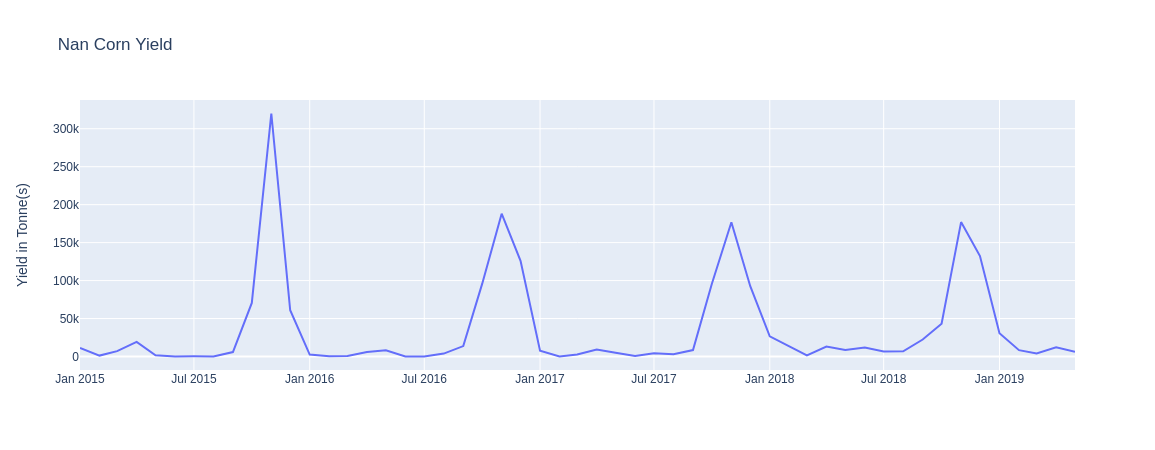

In [9]:
py.iplot({'data':go.Scatter(x=df_yield.index, y=df_yield['y'], name='y'),
         'layout':dict(title = 'Nan Corn Yield',
                       yaxis = dict(title = 'Yield in Tonne(s)'))
         })

In [10]:
first_diff = df_yield['y'].diff()[1:]

Text(0.5, 1.0, 'Diff yield')

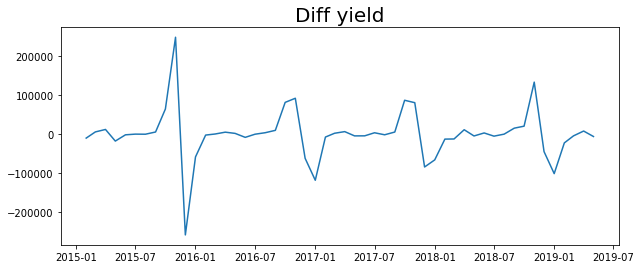

In [11]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('Diff yield', fontsize=20)
# plt.ylabel('Sales', fontsize=16)
# for year in range(start_date.year,end_date.year):
#     plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
# plt.axhline(0, color='k', linestyle='--', alpha=0.2)

# ACF

/home/yoyo/anaconda3/envs/oae/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:652: FutureWarning:

The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.

/home/yoyo/anaconda3/envs/oae/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:662: FutureWarning:

fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.



<BarContainer object of 20 artists>

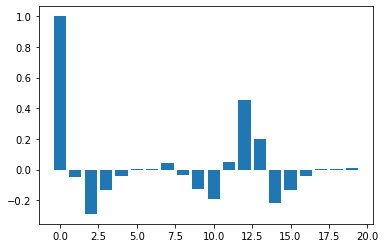

In [12]:
acf_vals = acf(first_diff)
num_lags = 20
plt.bar(range(num_lags), acf_vals[:num_lags])

## Based on ACF, we should start with a seasonal MA process

# PACF

/home/yoyo/anaconda3/envs/oae/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning:

invalid value encountered in sqrt



<BarContainer object of 15 artists>

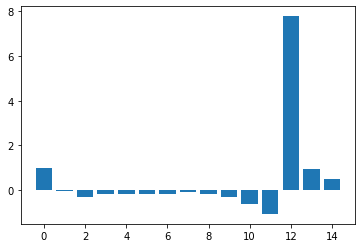

In [13]:
pacf_vals = pacf(first_diff, nlags=20)
num_lags = 15
plt.bar(range(num_lags), pacf_vals[:num_lags])

## Based on PACF, we should start with a seasonal AR process

# Get training and testing sets

In [14]:
df_train, df_test = df_yield[:-12], df_yield[-12:]

In [15]:
df_train.head()

,y,cost,precipitation,rainday,price,on_season
ds,,,,,,
2015-01-01,11233,4526.63,58.82,4.0,8.59,0.0
2015-02-01,1195,4526.63,3.88,3.0,8.75,0.0
2015-03-01,7079,4526.63,37.35,8.0,8.18,0.0
2015-04-01,19287,4526.63,136.02,14.0,8.11,0.0
2015-05-01,1585,4526.63,68.55,21.0,8.33,0.0


In [16]:
df_test.head()

,y,cost,precipitation,rainday,price,on_season
ds,,,,,,
2018-06-01,11754,4421.48,230.71,29.0,8.63,0.0
2018-07-01,6735,4421.48,346.97,27.0,7.17,0.0
2018-08-01,6864,4421.48,261.05,29.0,6.77,0.0
2018-09-01,22393,4421.48,164.82,22.0,6.56,0.0
2018-10-01,43070,4421.48,47.51,18.0,7.22,1.0


# Fit the SARIMA Model

In [17]:
endog = df_train.loc[:, 'y']
# exog = sm.add_constant(df_train.loc[:, ['cost', 'precipitation', 'rainday', 'price', 'on_season']])
exog = df_train.loc[:, ['cost', 'precipitation', 'rainday', 'price']]

In [18]:
my_order = (1,0,1)
my_seasonal_order = (0, 1, 0, 12)
# define model
model = SARIMAX(endog=endog, exog=exog, order=my_order, seasonal_order=my_seasonal_order)

In [19]:
%%time
#fit the model
model_fit = model.fit()

CPU times: user 223 ms, sys: 7.96 ms, total: 231 ms
Wall time: 230 ms


In [20]:
#summary of the model
print(model_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                   41
Model:             SARIMAX(1, 0, 1)x(0, 1, [], 12)   Log Likelihood                -330.788
Date:                             Thu, 08 Oct 2020   AIC                            675.575
Time:                                     15:55:46   BIC                            685.146
Sample:                                 01-01-2015   HQIC                           678.573
                                      - 05-01-2018                                         
Covariance Type:                               opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
cost             13.2005     15.920      0.829      0.407     -18.003      44.404
precipitation     

In [21]:
# exog_forecast = sm.add_constant(df_test.loc[:, ['cost', 'precipitation', 'rainday', 'price', 'on_season']])
exog_forecast = df_test.loc[:, ['cost', 'precipitation', 'rainday', 'price']]

In [22]:
#get the predictions and residuals
predictions = model_fit.forecast(len(df_test), exog=exog_forecast)
# predictions = pd.Series(predictions, index=df_test.index)
predictions.index = df_test.index
residuals = df_test['y'] - predictions

Text(0, 0.5, 'Error')

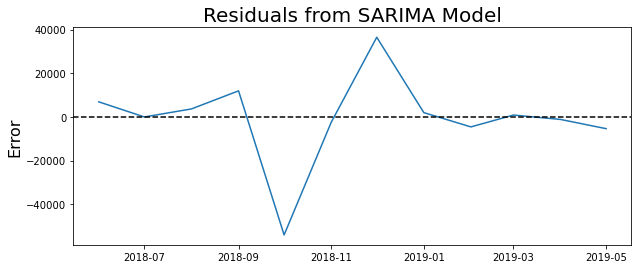

In [23]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

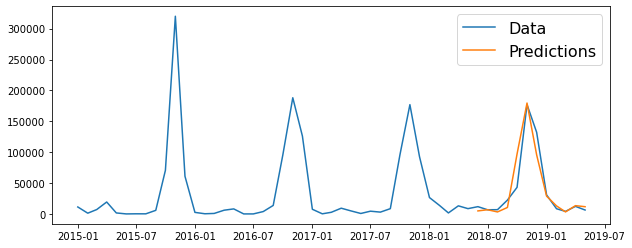

In [24]:
plt.figure(figsize=(10,4))

plt.plot(df_yield['y'])
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

In [25]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals / df_test['y'])),4))

Mean Absolute Percent Error: 0.4137


In [26]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 19397.25006248038
